# Testing performance of `compile_routine` with 1000 children

First setup the environment by doing any necessary package installs. Next, the necessary modules are imported and then `perf_results.txt` that resulted from `python -m cProfile -o perf_results.txt perf_test.py` is imported.

In [1]:
import pstats
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy


In [2]:
# test object containing a list of tuples of (name, directory, results)
test_python3_10 = [
    ("v0.10.0", "./performance_data/python3.10.16/0.10.0", ()),
    ("v0.11.0", "./performance_data/python3.10.16/0.11.0", ()),
    ("v0.12.0", "./performance_data/python3.10.16/0.12.0", ()),
    ("latest", "./performance_data/python3.10.16/latest", ()),
    ("latest-transitive", "./performance_data/python3.10.16/latest-transitive", ()),
]
test_python3_11 = [
    ("v0.10.0", "./performance_data/python3.11.9/0.10.0", ()),
    ("v0.11.0", "./performance_data/python3.11.9/0.11.0", ()),
    ("v0.12.0", "./performance_data/python3.11.9/0.12.0", ()),
    ("latest", "./performance_data/python3.11.9/latest", ()),
    ("latest-transitive", "./performance_data/python3.11.9/latest-transitive", ()),
]

The information is then transformed into a list of dictionary objects which is then used to create a pandas DataFrame. 

In [3]:
def stats_to_df(raw_stats_data):
    # List to hold our data records
    data_records = []

    for (file, line, func), (ncalls, recursive_ncalls, tottime, cumtime, callers) in raw_stats_data.items():
        # Calculate per-call times, handling potential division by zero if ncalls is 0
        # tottime / ncalls (if ncalls > 0)
        percall_tottime = tottime / ncalls if ncalls > 0 else 0
        # cumtime / ncalls (if ncalls > 0)
        percall_cumtime = cumtime / ncalls if ncalls > 0 else 0

        # Optionally strip directory paths for cleaner display
        cleaned_file = os.path.basename(file) if file not in ('~', '<string>') else file # Handle special cases

        data_records.append({
            'file': file, # Keep original file path as well
            'cleaned_file': cleaned_file, # Add a column with cleaned paths
            'line': line,
            'function': func,
            'ncalls': ncalls,
            'recursive_ncalls': recursive_ncalls, # Included for completeness, less commonly used
            'tottime': tottime,
            'percall_tottime': percall_tottime,
            'cumtime': cumtime,
            'percall_cumtime': percall_cumtime,
            # 'callers': callers # You could include callers, but it's complex data structure
        })

    # Create the pandas DataFrame
    df = pd.DataFrame(data_records)
    return df


 This function gathers the average runtime stats from the 5 runs and returns the mean and standard devitation of the runtimes full runtimes.

In [4]:
def runtime_stats_avg_of_directory(directory):
    total_time = 0.0
    files = 0
    cumulative_times = []
    std_dev = 0.0
    for filename in os.listdir(directory):
        if filename.endswith(".prof"):
            filepath = os.path.join(directory, filename)
            raw_stats = pstats.Stats(filepath).stats
            df = stats_to_df(raw_stats)
            cumulative_times.append(df['cumtime'].max())
    return (numpy.mean(cumulative_times), numpy.std(cumulative_times))



Below is plotting the mean runtimes and standard deviations of running `compile_routine` with 1000 children. This test was done for two versions of Python (3.10.16 and 3.11.9) and for versions 0.10.0, 0.11.0, 0.12.0, the latest (as of 5/14/25), and the latest (as of 5/14/25) with `transitive_resources=True`.

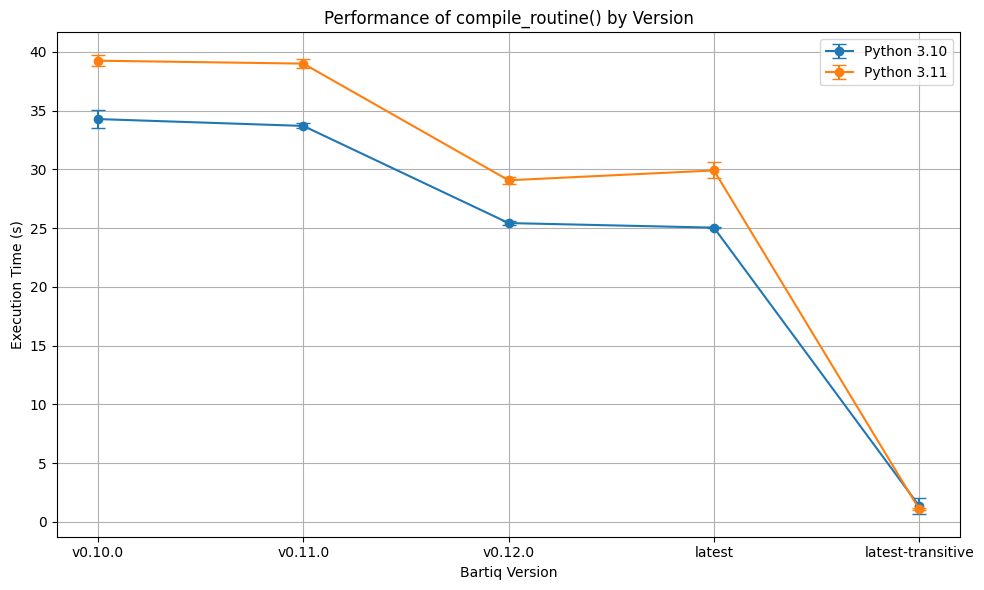

In [5]:
plt.figure(figsize=(10, 6))

test_data = [
    ("Python 3.10", test_python3_10), 
    ("Python 3.11", test_python3_11),
]
for index0, (pversion, test) in enumerate(test_data):
    means = []
    std_devs = []
    labels = []
    for index, (name, directory, results) in enumerate(test):
        new_results = runtime_stats_avg_of_directory(directory)
        test[index] = (name, directory, new_results)
        perf_mean, perf_std = new_results
        labels.append(name)
        means.append(perf_mean)
        std_devs.append(perf_std)
        
    test_data[index0] = test
    plt.errorbar(labels, means, yerr=std_devs, fmt="-o", capsize=5, label=pversion)



# Formatting
plt.legend()
plt.title("Performance of compile_routine() by Version")
plt.xlabel("Bartiq Version")
plt.ylabel("Execution Time (s)")
plt.grid(True)
plt.tight_layout()


Below is some info from a particular run. In this case it is using Python 3.10.16 and [latest Bartiq](https://github.com/PsiQ/bartiq/commit/aea7b177bab6395a262739bf10b7853e4faeda71) as of 5/14/25 with `transitive_resources` set to `False` and `True`. It is worth noting that throughout the tests SymPy took roughly 75% of the runtime for all instances without `transitive_resources=True`.

In [22]:
# Filter the DataFrame for entries related to sympy
# We'll look for 'sympy' in either the original 'file' column
# or the 'cleaned_file' column, depending on what you prefer to filter by.
# Let's use the original 'file' column for a more precise match to paths.

filepath = "./performance_data/python3.10.16/latest/perf_results_1.prof"
filepath_transitive = "./performance_data/python3.10.16/latest-transitive/perf_results_1.prof"

raw_stats = pstats.Stats(filepath)
raw_stats = raw_stats.stats
df = stats_to_df(raw_stats)

raw_stats_transitive = pstats.Stats(filepath_transitive)
raw_stats_transitive = raw_stats_transitive.stats
df_transitive = stats_to_df(raw_stats_transitive)

total_execution_time = df['cumtime'].max()
total_execution_time_transitive = df_transitive['cumtime'].max()

sympy_df = df[df['file'].str.contains('sympy', na=False)].copy().drop(columns=['file'])
total_sympy_time = sympy_df['tottime'].sum()

sympy_df_transitive = df_transitive[df_transitive['file'].str.contains('sympy', na=False)].copy().drop(columns=['file'])
total_sympy_time_transitive = sympy_df_transitive['tottime'].sum()

bartiq_df = df[df['file'].str.contains('PsiQuantum', na=False)].copy().drop(columns=['file'])
total_bartiq_time = bartiq_df['tottime'].sum()

bartiq_df_transitive = df_transitive[df_transitive['file'].str.contains('PsiQuantum', na=False)].copy().drop(columns=['file'])
total_bartiq_time_transitive = bartiq_df_transitive['tottime'].sum()
print("Latest Bartiq without using transitive resources")
print(f"Total time spent running SymPy functions: {total_sympy_time:.4f} seconds or { 100 * total_sympy_time / total_execution_time :.4f}% of execution time")
print(f"Total time spent running Bartiq functions: {total_bartiq_time:.4f} seconds or { 100 * total_bartiq_time / total_execution_time :.4f}% of execution time")
time_distribution = pd.Series({
    'SymPy Functions': total_sympy_time,
    'Bartiq Functions': total_bartiq_time,
    'Other Functions': total_execution_time - total_sympy_time - total_bartiq_time
})
print(time_distribution)

print("\nLastest Bartiq with using transitive resources")
print(f"Total time spent running SymPy functions: {total_sympy_time_transitive:.4f} seconds or { 100 * total_sympy_time_transitive / total_execution_time_transitive :.4f}% of execution time")
print(f"Total time spent running Bartiq functions: {total_bartiq_time_transitive:.4f} seconds or { 100 * total_bartiq_time_transitive / total_execution_time_transitive :.4f}% of execution time")
time_distribution_transitive = pd.Series({
    'SymPy Functions': total_sympy_time_transitive,
    'Bartiq Functions': total_bartiq_time_transitive,
    'Other Functions': total_execution_time_transitive - total_sympy_time_transitive - total_bartiq_time_transitive
})
print(time_distribution_transitive)


Latest Bartiq without using transitive resources
Total time spent running SymPy functions: 19.4954 seconds or 77.9768% of execution time
Total time spent running Bartiq functions: 0.2349 seconds or 0.9395% of execution time
SymPy Functions     19.495388
Bartiq Functions     0.234882
Other Functions      5.271259
dtype: float64

Lastest Bartiq with using transitive resources
Total time spent running SymPy functions: 0.1871 seconds or 7.0518% of execution time
Total time spent running Bartiq functions: 0.2233 seconds or 8.4142% of execution time
SymPy Functions     0.187102
Bartiq Functions    0.223251
Other Functions     2.242900
dtype: float64


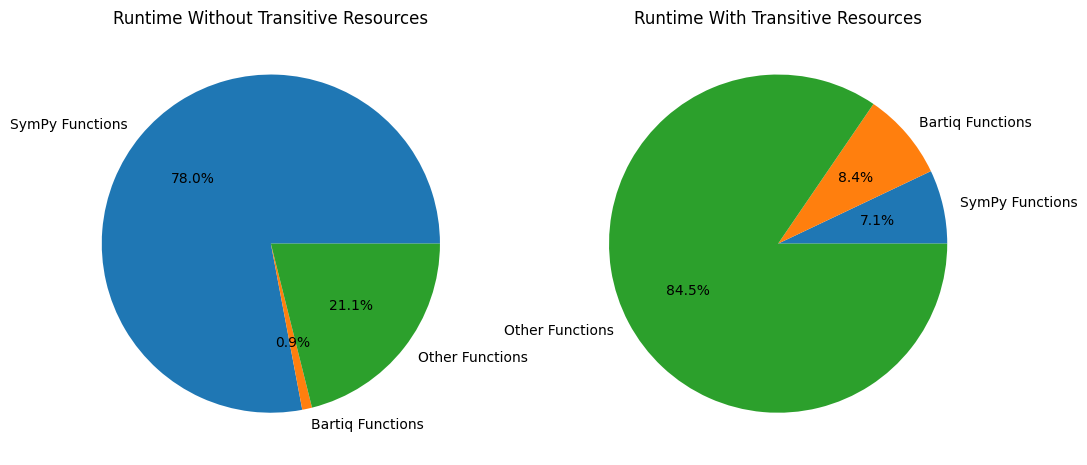

In [23]:
# Create the pie charts
fig, axes = plt.subplots(1,2, figsize=(12,6))

time_distribution.plot.pie(
    ax=axes[0],
    autopct='%1.1f%%',
    labels=time_distribution.index, # Use the Series index for labels
    ylabel='',
)
axes[0].set_title( 'Runtime Without Transitive Resources')

time_distribution_transitive.plot.pie(
    ax=axes[1],
    autopct='%1.1f%%',
    labels=time_distribution_transitive.index, # Use the Series index for labels
    ylabel='',
)
axes[1].set_title( 'Runtime With Transitive Resources')

plt.show() # Display the plot

In [18]:
top_10_sympy_functions_by_tottime = sympy_df.sort_values(by='tottime', ascending=False).head(10)
top_10_sympy_functions_by_cumulate_time = sympy_df.sort_values(by='cumtime', ascending=False).head(10)
top_10_bartiq_functions_by_tottime = bartiq_df.sort_values(by='tottime', ascending=False).head(10)
top_10_bartiq_functions_by_cumulate_time = bartiq_df.sort_values(by='cumtime', ascending=False).head(10)

In [20]:
top_10_bartiq_functions_by_tottime

,cleaned_file,line,function,ncalls,recursive_ncalls,tottime,percall_tottime,cumtime,percall_cumtime
4542,_compile.py,205,<dictcomp>,3002,3002,0.133931,4.461402e-05,0.158882,5.292538e-05
2464,sympy_backend.py,190,<listcomp>,2002,2002,0.016812,8.397675e-06,0.036058,1.801095e-05
4549,_compile.py,271,_compile,1,1001,0.016100,1.610039e-02,24.378800,2.437880e+01
4445,ast_parser.py,306,parse,4000,4000,0.004675,1.168854e-06,0.094001,2.350023e-05
4436,ast_parser.py,180,_preprocess,4000,4000,0.003436,8.589375e-07,0.009647,2.411631e-06
2431,_routine.py,155,from_qref,1,1001,0.003316,3.316330e-03,0.106151,1.061507e-01
2417,_routine.py,105,__post_init__,7006,7006,0.002947,4.206974e-07,0.003481,4.968487e-07
2465,sympy_backend.py,180,substitute,2002,2002,0.002339,1.168335e-06,24.019815,1.199791e-02
4441,ast_parser.py,263,_,4000,4000,0.002299,5.748375e-07,0.027094,6.773532e-06
2457,sympy_backend.py,85,parse_to_sympy,4000,4000,0.001870,4.675195e-07,0.096261,2.406525e-05


In [21]:
top_10_sympy_functions_by_tottime

,cleaned_file,line,function,ncalls,recursive_ncalls,tottime,percall_tottime,cumtime,percall_cumtime
2778,basic.py,2137,is_same,2017980,2017980,4.252448,2.107279e-06,12.215199,6.053181e-06
3153,symbol.py,395,_hashable_content,4458270,4458270,1.743251,3.910152e-07,3.585179,8.041637e-07
2758,basic.py,450,_do_eq_sympify,4035769,4035769,1.446183,3.583413e-07,1.870457,4.634698e-07
2759,basic.py,469,__eq__,6055866,6055866,1.407329,2.323911e-07,5.375611,8.876701e-07
2753,basic.py,307,compare,1301022,1301022,1.265309,9.725504e-07,3.572098,2.745609e-06
2738,cache.py,69,wrapper,8150,2031813,1.204003,1.477304e-04,24.019744,2.947208e-03
2903,traversal.py,246,postorder_traversal,8085708,8109286,1.182933,1.462993e-07,1.525725,1.886941e-07
2772,basic.py,1200,fallback,2000,1004994,0.829269,4.146347e-04,23.738165,1.186908e-02
3005,mul.py,465,_gather,4002,4002,0.752881,1.881263e-04,1.635820,4.087505e-04
3155,symbol.py,407,assumptions0,4458270,4458270,0.723228,1.622217e-07,1.214764,2.724743e-07
